# Comprehensive Analysis of the American Used Car Market: Price Trends and Predictive Modeling

Collaborators: Aarmabh Sanoria, Emily Sheridan, Lucia Soto Garcia, Ammar Khawaja

# Introduction

Daily travel in the US is largely dominated by cars. Cars are a necessary part of American life due to the current state of public transportation. Very few places in America can boast adequate public transportation, and 45% of Americas have no access to public transportation (Source: [APTA](https://www.apta.com/news-publications/public-transportation-facts/)). As a result, the American commute is primarily made via car, with 76% of American commuters using a personal vehicle to get to their workplace (Source: [World Economic Forum](https://www.weforum.org/agenda/2022/05/commute-america-sustainability-cars/)). For these Americans, their livelihood is tied to access to a car.


In recent years, the spike in prices of new cars and trucks has caused many Americans to look towards buying used cars when the need for a new car arises (Sources: [CBS](https://www.cbsnews.com/newyork/news/car-values-increasing-along-with-demand-for-used-vehicles-average-years-on-the-road/), [Major World](https://www.majorworld.com/why-are-more-people-buying-used-cars-in-2024/)). In 2023, the average price of a new car had increased by around $10,000 since 2020, largely because of inflation and manufacturing delays related to the COVID-19 pandemic (Source: [Consumer Reports](https://www.consumerreports.org/cars/buying-a-car/people-spending-more-on-new-cars-but-prices-not-necessarily-rising-a3134608893/)). Many manufacturers have also divested from their more affordable models in favor of models that produce more profit (Source: [Consumer Reports](https://www.consumerreports.org/cars/buying-a-car/people-spending-more-on-new-cars-but-prices-not-necessarily-rising-a3134608893/)).

Used car prices have also risen to meet the growing demand, but these vehicles are still seen by many as a more affordable and adequate alternative to a new vehicle.

In our project, we hope to develop a price predictor for used cars based on a combination of various features, including the location of car (state), the year the car was built, the manufacturer, the number of miled on the car (odometer), etc. This price predictor could be useful for people looking to sell used cars to ensure (1) they are asking a reasonable price for their car and (2) they are receiving resonable offers for their car to avoid low-balling from buyers. It could also be useful for people looking to buy a used car to ensure that they are not taken advantage of by sellers hiking up the price of their car.

Over this tutorial we will be going through the Data Science Lifecycle as following:

Data Collection

*   Data Collection & Data Processing
*   Data Visualization
*   Model: Analysis, Hypothesis Testing, & ML
*   Interpretation: Insight & Policy Decision




## **Imports**
We will start by including some libraries for our analysis



In [ ]:
import numpy as np
import pandas as pd
import os
import datetime as dt
from dateutil import parser
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
import statsmodels.api as sm
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow import keras
from keras import layers
from keras import regularizers
from keras.layers import Dense, Dropout
from keras.models import Sequential
from joblib import parallel_backend
import gc

# **Data Collection**
The initial phase of our analysis involves data extraction. Our focus will be on the collaboration between different regions, so it would be beneficial to gather some general data on these regions, such as the type of vehicles commonly found there. Although our current analysis does not consider the state of the region, it might be intriguing to incorporate this variable in future studies.

All the data was sourced from the following link which contains information about various vehicles, their conditions, prices, and other relevant details.

Data was downloaded from https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data

In [ ]:
data = pd.read_csv('data.csv', on_bad_lines='warn')

# **Data Processing**
Now that we have our dataframe we need to clean our dataset of vehicle information. The primary focus is on correcting inconsistencies in the column, replacing missing data, and removing unnecessary columns, thereby preparing the data for further analysis or modeling.

We'll begin by limiting our data to cars made in 2001 or later. This was chosen because the average year in our dataset is 2011 and the standard deviation is ~9.5 years. Rounding up to 10 years, one standard deviation below the mean is 2001. Limiting our data to cars manufactured after 2001 maintains 92.97% of our original data. We also exclude cars produced in 2022 since we are interested in used cars. Moreover, we also removed some columns whose information was not particularly relevant.

In [ ]:
data.drop(columns=['id','VIN', 'paint_color', 'lat', 'long', 'size'], inplace=True)
data.describe()

,price,year,odometer
count,4.268530e+05,425675.000000,4.224800e+05
mean,7.520308e+04,2011.235191,9.804333e+04
std,1.218267e+07,9.452120,2.138815e+05
min,0.000000e+00,1900.000000,0.000000e+00
25%,5.900000e+03,2008.000000,3.770400e+04
50%,1.395000e+04,2013.000000,8.554800e+04
75%,2.648800e+04,2017.000000,1.335425e+05
max,3.736929e+09,2022.000000,1.000000e+07


We now drop rows with missing data from our data frame. This still leaves us with plenty of data to work with and avoids a false perception of data.

In [ ]:
data = data[data['year']>2000]
data = data[data['year']<2022]
data = data.dropna()

Because the type of information given by region varies (some values are cities, some are states, some are parts of states, some are large geographic regions, etc.), we will not use region in our data analysis. Instead, we will use state to determine the geographic location of the vehicle. Here, we drop region and format state values to be uppercase, as is the standard for state abbreviations.

In [ ]:
# Dropping region & formatting state
data.drop('region', axis=1, inplace=True)
data['state'] = data['state'].apply(lambda x: x.upper())

<ipython-input-5-df9f8385ac89>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('region', axis=1, inplace=True)
<ipython-input-5-df9f8385ac89>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['state'] = data['state'].apply(lambda x: x.upper())


We now want ensure consistent formatting of year and posting date.

In [ ]:
# Set format of year and posting_date
data['year'] = pd.to_datetime(data['year'], format='%Y').dt.strftime('%Y')
data['posting_date'] =  pd.to_datetime(data['posting_date'], utc=True, format='mixed').dt.strftime('%m-%d-%Y')

We next add a column for car age, which is calculated by subtracting the model year from the year of posting (2021). If the model is 2022, the car age is set to 0. If the age is unknown, it is also set to 0.

In [ ]:
# Calculate car age based on posting date and year
data.loc[:, 'car_age'] = data['posting_date'].str[-4:].astype(float) - data['year'].astype(float)

# Replacing cars with negative or no age to have age of 0
data['car_age'] = data['car_age'].replace(-1.0, 0.0)
data['car_age'] = data['car_age'].replace(np.nan, 0.0)

#Rearranging the columns for organization
data = data[['state', 'price', 'year', 'car_age', 'manufacturer', 'model', 'condition', 'odometer', 'title_status', 'transmission', 'posting_date','cylinders', 'fuel', 'drive', 'type']]

Now we will format the cylinder column to contain only an integer representing the number of cylinders.

In [ ]:
data = data[data['cylinders'] != 'other']
data.loc[:,'cylinders'] = data['cylinders'].apply(lambda x: int(x.split(' ')[0]))
data['cylinders'] = data['cylinders'].astype(int)

We now move on to properly format the manufacturer column to capitalize the brand names.

In [ ]:
# Format manufacturers
def replace(a,b):
    data["manufacturer"].replace(a,b,inplace=True)

# Hyphonated/Two Word Names
replace('mercedes-benz','Mercedes-Benz')
replace('alfa-romeo','Alfa-Romeo')
replace('harley-davidson','Harley-Davidson')
replace('aston-marin','Aston-Martin')
replace('land rover','Land Rover')

# All Caps
replace('gmc', "GMC")
replace('bmw', 'BMW')

# Based on car models, 'rover' is 'land rover'
replace('rover','Land Rover')

# Capitalize every manufacturer that is not already formatted
data["manufacturer"] = data["manufacturer"].astype(str).apply(lambda x: x.capitalize() if x and not x[0].isupper() else x)

Next, we'll ensure that the dtype of year is an integer.

In [ ]:
data.dtypes

state            object
price             int64
year             object
car_age         float64
manufacturer     object
model            object
condition        object
odometer        float64
title_status     object
transmission     object
posting_date     object
cylinders         int64
fuel             object
drive            object
type             object
dtype: object

In [ ]:
def data_type_chnge(ch):
  data[ch] = pd.to_numeric(data[ch], errors='coerce')
  data[ch].fillna(0, inplace=True)
  data[ch] = data[ch].astype(int)

chn= ['year']
for i in chn:
  data_type_chnge(i)

We noticed a handful of outliers with prices that are beyond reasonable. We drop these outliers here.

In [ ]:
data[data['price'] > 1000000] # Outliers
data = data[data['price'] < 1000000] # Drop the outliers

After cleaning, we are left with 115,497 data observations.
Our dataframe is the following format:

In [ ]:
print('Dimensions: {} x {}'.format(data.shape[0], data.shape[1]))
data.head(5)

Dimensions: 115497 x 15


,state,price,year,car_age,manufacturer,model,condition,odometer,title_status,transmission,posting_date,cylinders,fuel,drive,type
4,AL,15000,2013,8.0,Ford,f-150 xlt,excellent,128000.0,clean,automatic,05-03-2021,6,gas,rwd,truck
5,AL,27990,2012,9.0,GMC,sierra 2500 hd extended cab,good,68696.0,clean,other,05-03-2021,8,gas,4wd,pickup
6,AL,34590,2016,5.0,Chevrolet,silverado 1500 double,good,29499.0,clean,other,05-03-2021,6,gas,4wd,pickup
7,AL,35000,2019,2.0,Toyota,tacoma,excellent,43000.0,clean,automatic,05-03-2021,6,gas,4wd,truck
8,AL,29990,2016,5.0,Chevrolet,colorado extended cab,good,17302.0,clean,other,05-03-2021,6,gas,4wd,pickup


# **Data Visualization**

Data visualization plays a crucial role in understanding the underlying patterns and insights within our dataset. By visually representing the data, we can more easily identify trends, outliers, and distributions that might not be apparent from raw data alone. In this section, we explore various aspects of the used car market, including manufacturer popularity, price depreciation by car age, and regional price variations. Each visualization is designed to help us draw meaningful conclusions that can inform both sellers and buyers in the used car market.

**Proportion of Vehicles by Manufacturer**

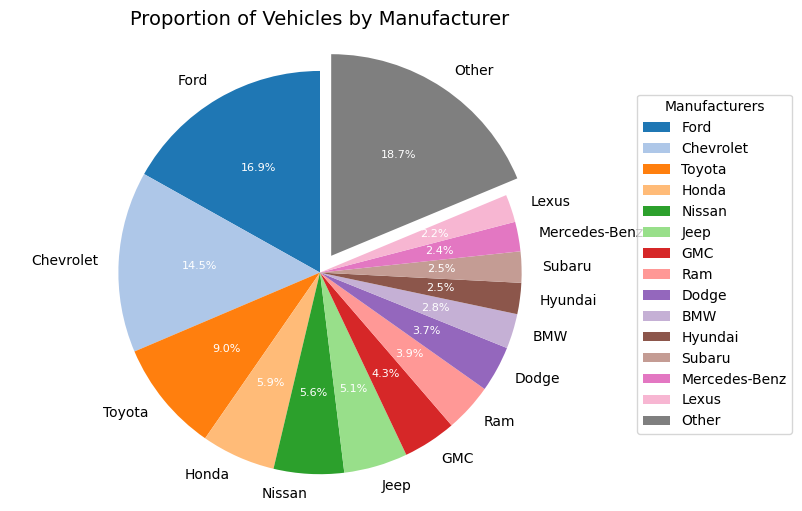

In [ ]:
manufacturer_counts = data['manufacturer'].value_counts()

threshold = 0.02 * manufacturer_counts.sum()
other_count = manufacturer_counts[manufacturer_counts < threshold].sum()
manufacturer_counts = manufacturer_counts[manufacturer_counts >= threshold]
manufacturer_counts['Other'] = other_count

colors = sns.color_palette('tab20', len(manufacturer_counts))

fig, ax = plt.subplots(figsize=(8, 6))
wedges, texts, autotexts = ax.pie(manufacturer_counts, labels=manufacturer_counts.index, autopct='%1.1f%%', startangle=90, colors=colors, explode=[0.1 if i == 'Other' else 0 for i in manufacturer_counts.index])


for text in texts:
    text.set_fontsize(10)
for autotext in autotexts:
    autotext.set_fontsize(8)
    autotext.set_color('white')

ax.axis('equal')
plt.title('Proportion of Vehicles by Manufacturer', fontsize=14)
plt.legend(wedges, manufacturer_counts.index, title="Manufacturers", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

This visualization is a pie chart that shows the proportion of vehicles listed for sale by different manufacturers in 2021. This helps us understand which car manufacturers dominate the used car market. A significant presence in the market can indicate popular brands that are preferred by consumers for their reliability, resale value, or availability of parts. From the pie chart, it is evident that Ford and Chevrolet are the most popular manufacturers, indicating a strong preference for these brands among used car buyers. This popularity might be attributed to their reputation for reliability and the wide availability of parts and services.

**Average Price of a Used Car by Age**


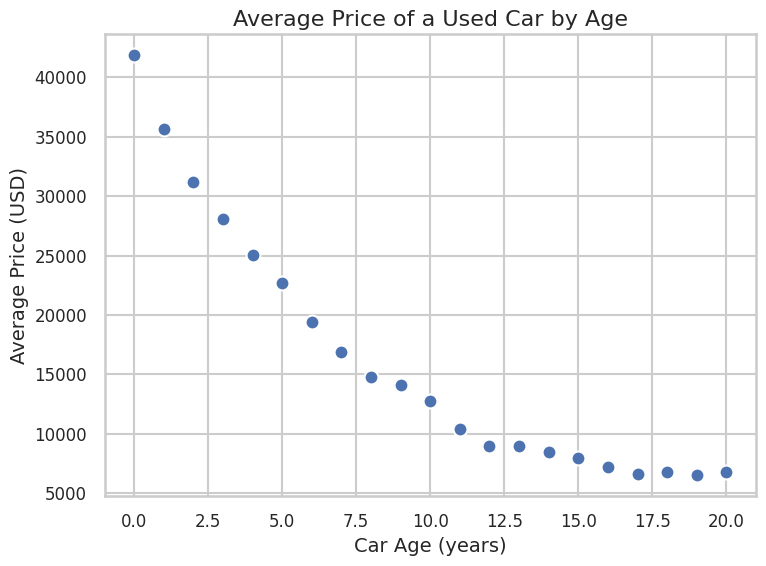

In [ ]:
# Calculate the average price of a car for each age group
avgs = data.groupby("car_age").describe()
avg_prices = avgs['price']['mean']

sns.set(style="whitegrid", context="talk")
plt.figure(figsize=(8, 6))
sns.scatterplot(x=avg_prices.index, y=avg_prices, s=100, color='b', edgecolor='w', linewidth=1.5)
plt.xlabel('Car Age (years)', fontsize=14)
plt.ylabel('Average Price (USD)', fontsize=14)
plt.title('Average Price of a Used Car by Age', fontsize=16)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

This scatter plot illustrates how the age of a car impacts its market price, providing insights into the depreciation rate of cars. The plot clearly shows that as cars age, their average price tends to decrease. This trend underscores the importance of considering car age when setting prices or making purchase decisions, as older cars generally offer more value for money but might come with higher maintenance costs.


**Average Price of a Used Car by Manufacturer**

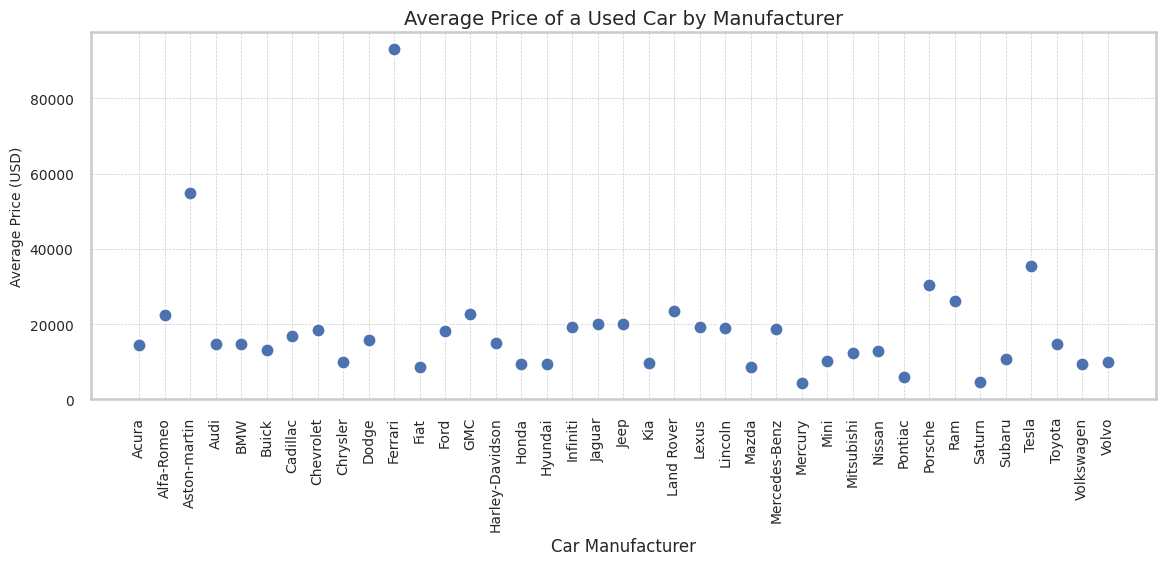

In [ ]:
# Calculate the price statistics of a car for each manufacturer
avgs = data.groupby("manufacturer").describe()
avg_prices = avgs['price']['mean']

sns.set(style="whitegrid", context="talk")
plt.figure(figsize=(12, 6))
sns.scatterplot(x=avg_prices.index, y=avg_prices, s=100, color='b', edgecolor='w', linewidth=1.5)
plt.xlabel('Car Manufacturer', fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.ylabel('Average Price (USD)', fontsize=10)
plt.yticks(fontsize=10)
plt.title('Average Price of a Used Car by Manufacturer', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

This scatter plot shows the average price of used cars by manufacturer, highlighting the premium associated with different brands. It appears that each manufacturer has a distinct set of prices. Additionally, the visualization reveals that luxury brands like Ferrari and Aston Martin command higher average prices in the used car market. It is also interesting to note that most cars from various brands can be bought for under or around the $20,000 mark.

A violin plot will give us an idea of how the data is distributed for each manufacturer. For more detailed information on using and making violin plots, see this helpful [guide to violin plots](https://www.atlassian.com/data/charts/violin-plot-complete-guide).

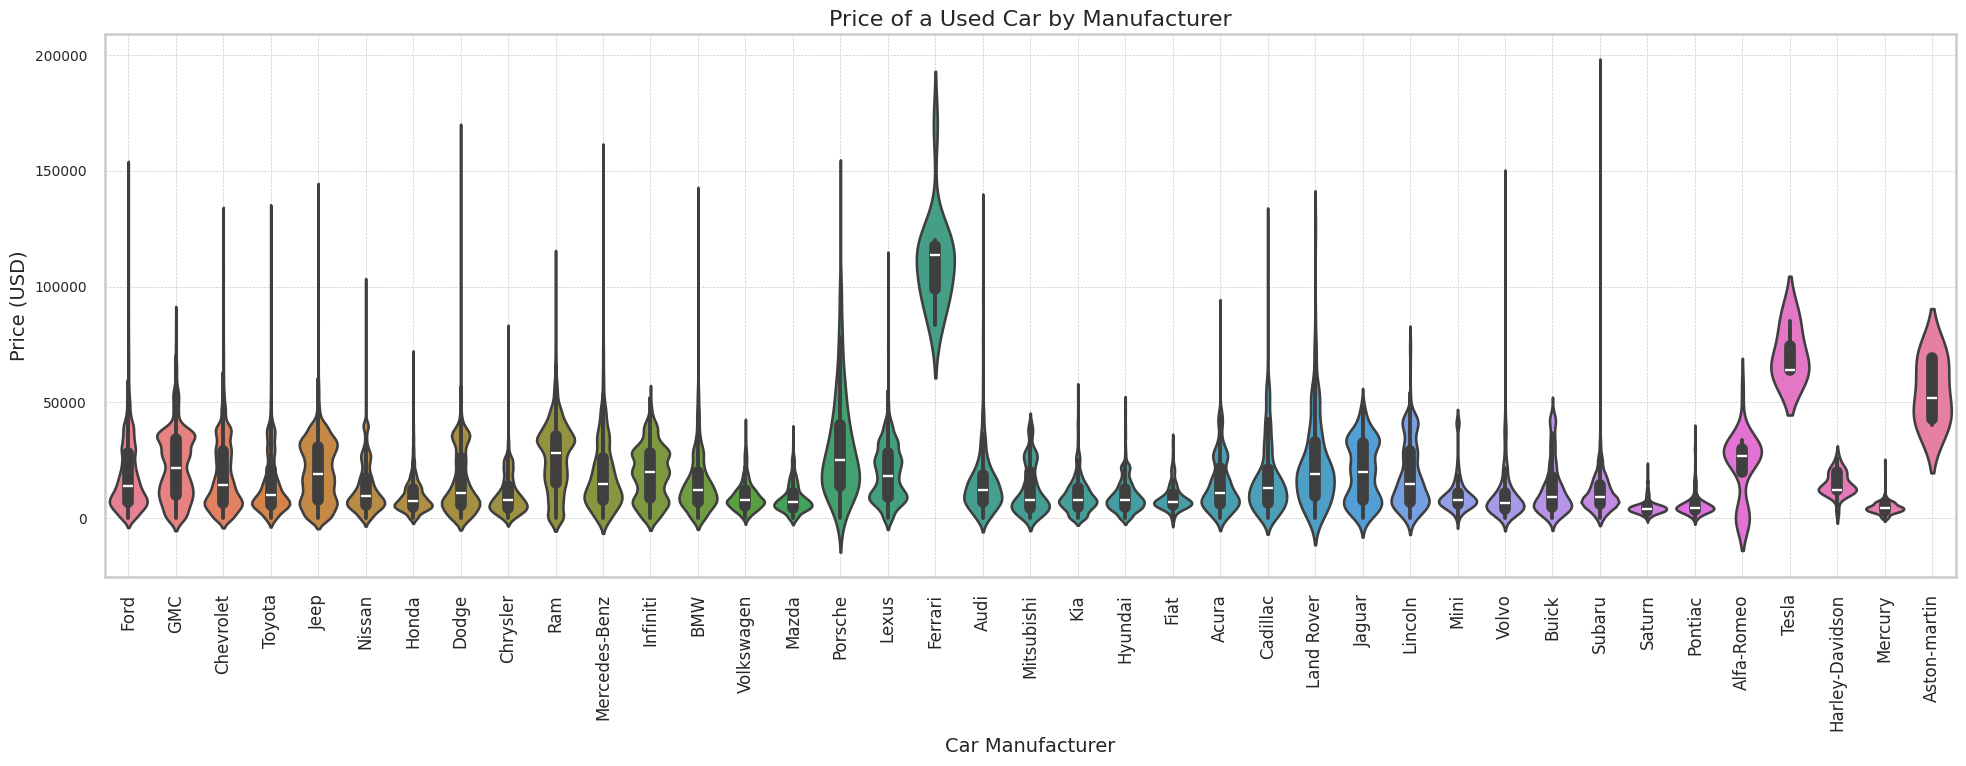

In [ ]:
# filtering to handle kernel density estimation used in seaborn
filtered_data = data[(data['price'] > 100) | ((data['manufacturer'] != 'Ferrari') & (data['manufacturer'] != 'Tesla'))]
# Create a violin plot for prices by manufacturer
sns.set(style="whitegrid", context="talk")
plt.figure(figsize=(20, 8))
palette = sns.color_palette("husl", len(filtered_data['manufacturer'].unique()))
sns.violinplot(data=filtered_data, x='manufacturer', y='price', hue='manufacturer', palette=palette, dodge=False, legend=False)
plt.xlabel('Car Manufacturer', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.ylabel('Price (USD)', fontsize=14)
plt.yticks(fontsize=10)
plt.title('Price of a Used Car by Manufacturer', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

The manufacturers have different distributions of prices, although some manufacturers (e.g. Volkswagen and Mazda) have similar distributions. Ferrari and Aston Martin have a wider distribution at higher price points, indicating that their cars are generally more expensive.The boxes for these brands are positioned higher on the price scale, indicating higher median prices. Porsche and Mercedes-Benz also show a significant spread towards higher prices, though not as extreme as Ferrari and Aston Martin. This indicates that while they have some more affordable models, they also have many high-end, expensive cars. Ford, Chevrolet, Toyota, and Honda have a more concentrated distribution around lower price points, typically under $20,000. The violins are wider in the lower price range, indicating a higher density of cars in this range. This suggests that these brands are more accessible to a broader range of buyers. The violin for Tesla is intresting which shows a concentration of prices in the mid to high range, reflecting the premium nature of their electric vehicles.


**Average Price of a Used Car by State**

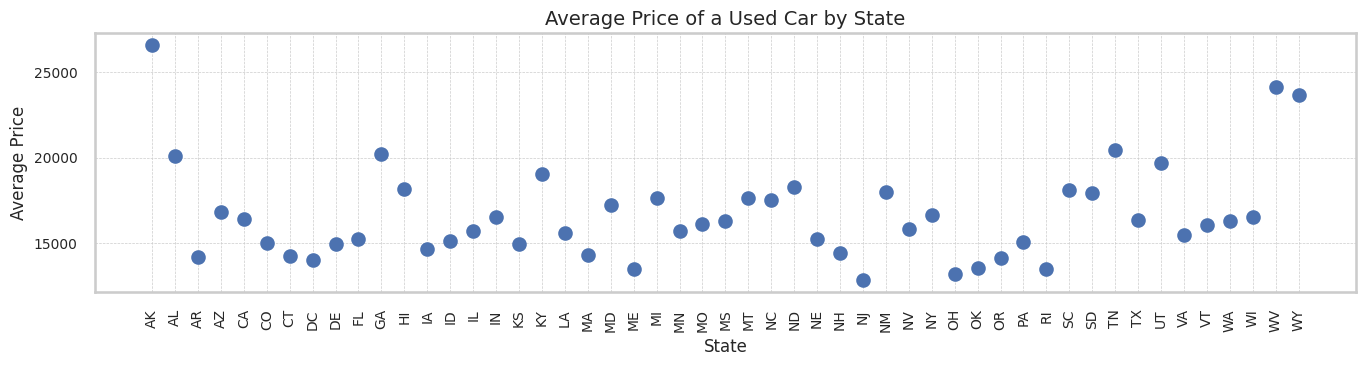

In [ ]:
# Calculate the price statistics of a car for each state
avgs = data.groupby("state").describe()

# Plot average price for each state
plt.figure(figsize=(14, 4))
plt.scatter(avgs.index, avgs['price']['mean'])
plt.xlabel('State', fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.ylabel('Average Price', fontsize=12)
plt.yticks(fontsize=10)
plt.title('Average Price of a Used Car by State', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

The scatter plot reveals significant regional variations in the average price of used cars. States like Alaska and Wyoming have higher average prices, possibly due to supply constraints and higher transportation costs. In contrast, states like Michigan and Ohio have lower average prices, likely influenced by higher supply and lower demand. Understanding these regional differences can help buyers and sellers make more informed decisions based on local market conditions.

Now lets create a violin plot for prices by state

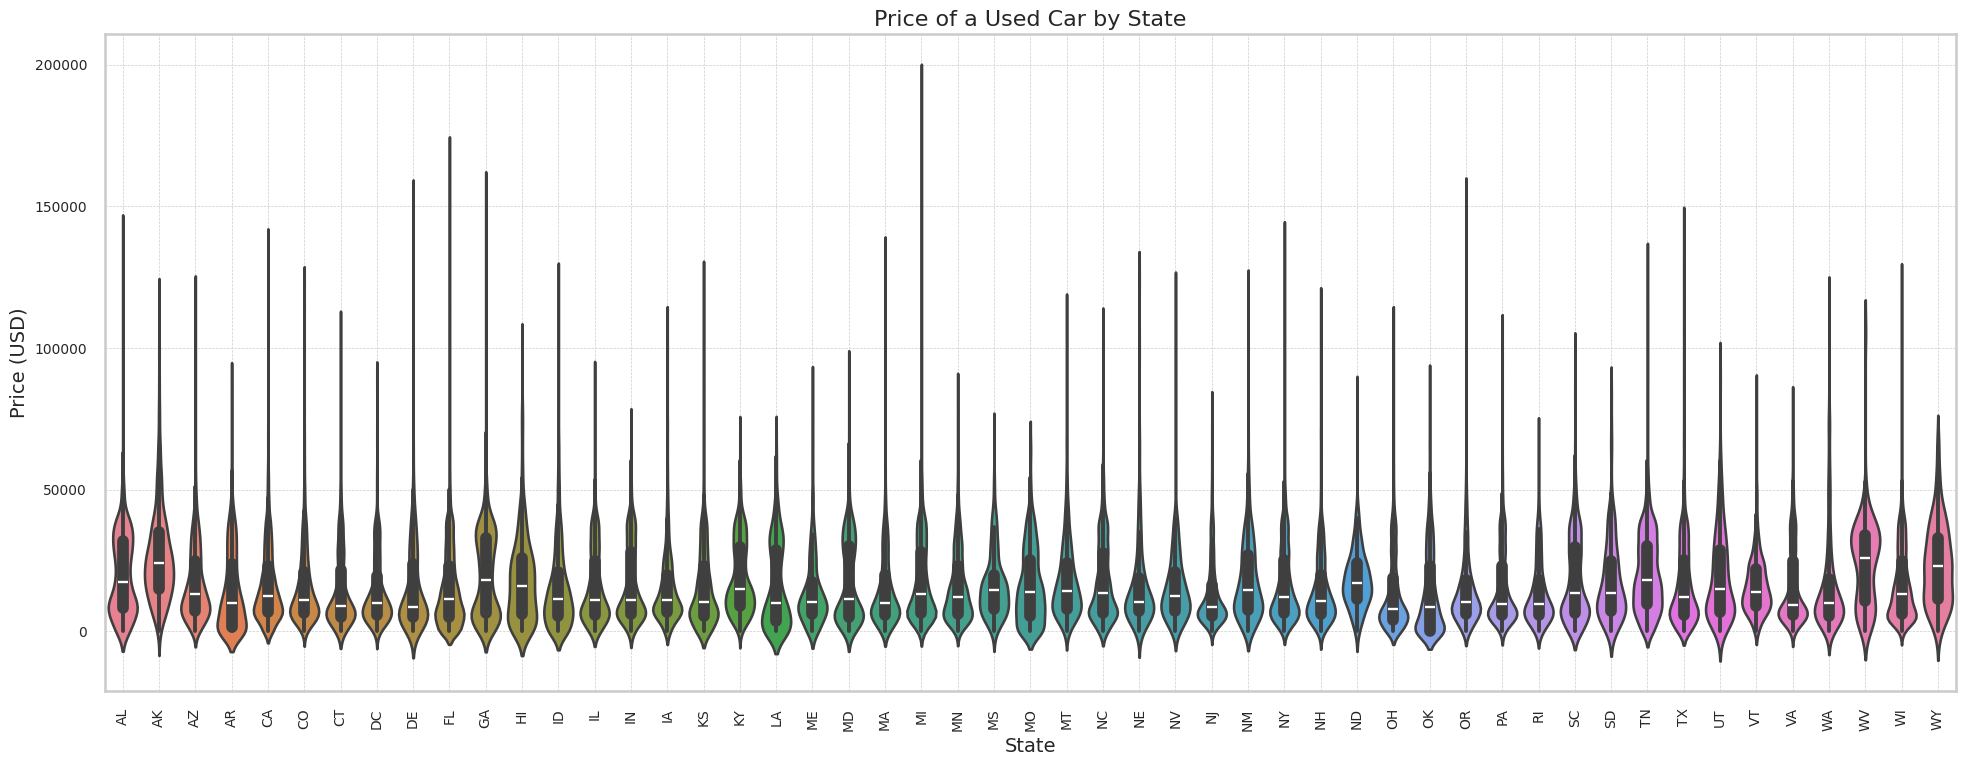

In [ ]:
# Create a violin plot for prices by state
sns.set(style="whitegrid", context="talk")
plt.figure(figsize=(20, 8))
palette = sns.color_palette("husl", len(data['state'].unique()))
sns.violinplot(data=data, x='state', y='price', hue='state', palette=palette, dodge=False, legend=False)
plt.xlabel('State', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.ylabel('Price (USD)', fontsize=14)
plt.yticks(fontsize=10)
plt.title('Price of a Used Car by State', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

The violin plots, combined with the box plots inside them, provide a comprehensive view of the price distributions for used cars across different states. States like Alaska and Wyoming have higher median prices and greater variance, indicating a higher density of expensive cars. In contrast, states like Michigan and Ohio have lower median prices and less variance, indicating a higher density of affordable cars. This aslo shows us that the bulk of the data for each state has a price of under 50,000 USD, but each state has varying levels of variation in the upper extreme of > 50,000 USD.

### Correlation -- Numeric Data

We are interested in correlation between numeric variables. We will now visualize correlation between numeric data.

In [ ]:
# Select numeric data
num_data = data.select_dtypes(include=[np.number])

# Compute pairwise correlation between columns
mat = pd.DataFrame(num_data).corr()
mat

,price,year,car_age,odometer,cylinders
price,1.000000,0.555635,-0.555635,-0.221816,0.364257
year,0.555635,1.000000,-1.000000,-0.249332,-0.063077
car_age,-0.555635,-1.000000,1.000000,0.249332,0.063077
odometer,-0.221816,-0.249332,0.249332,1.000000,0.016222
cylinders,0.364257,-0.063077,0.063077,0.016222,1.000000


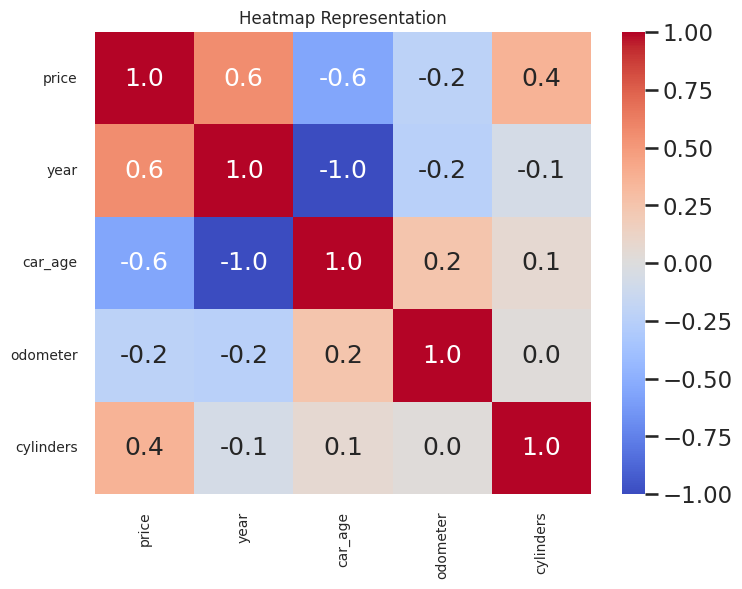

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(mat, annot=True, fmt=".1f", cmap='coolwarm', cbar=True)
plt.title('Heatmap Representation', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

The heatmap provides a visual representation of the correlations between different numeric variables related to used cars. Here, we notice a moderate positive correlation between price and year, as well as between cylinders and price. There is also a moderate negative correlation between price and car age, and weak correlations between price and odometer. Understanding these correlations further helps in predicting car prices and understanding the relationships between different car attributes.

# **ML**

We would like to train a model to predict a used car's price given the car's year, odometer, number of cylinders, manufacturer, state, condition, fuel-type, drive-type, and vehicle-type. Below, we fit a linear model using OLS and Lasso Regression, a KNN model, a Random Forest Model, and a Neural Network. We collected the score results for all of them so we could conclude which one is our most efficient model for the data that we are working with.

We'll begin by organizing the data for our model and standardizing numeric values.

In [ ]:
train_df = data[['price', 'year', 'odometer', 'cylinders', 'manufacturer', 'state', 'condition', 'fuel', 'drive', 'type']]

# Standardize numeric data
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
train_df.loc[:, numeric_cols] = scaler.fit_transform(train_df[numeric_cols])

In [ ]:
# Create df to hold model data
model_data = train_df
model_data.head()

,price,year,odometer,cylinders,manufacturer,state,condition,fuel,drive,type
4,-0.080792,0.235819,0.133530,0.040827,Ford,AL,excellent,gas,rwd,truck
5,0.875440,0.033917,-0.230876,1.300959,GMC,AL,good,gas,4wd,pickup
6,1.361285,0.841524,-0.471730,0.040827,Chevrolet,AL,good,gas,4wd,pickup
7,1.391466,1.447230,-0.388770,0.040827,Toyota,AL,excellent,gas,4wd,truck
8,1.022666,0.841524,-0.546677,0.040827,Chevrolet,AL,good,gas,4wd,pickup


In [ ]:
# Define a function to split data into test and training data
def split(X, y):
  # 80-20 ratio of train to test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10) # Set a random state so the split is reproducible
  return X_train, X_test, y_train, y_test

# Model Implementations

Now that we've gathered, refined, and analyzed our data, it's time to delve into constructing various models based off this data. We created linear regression, lasso regression, KNN, and neural network models to analyze the factors influencing the American used vehicle market. We'll utilize our independent variables such as vehicle condition, manufacturer, engine, and other factors, to develop these various models aimed at uncovering their correlations with a used vehicle's market value.

## Linear regression

We start with a multi-variate linear regression model, trained using OLS (Ordinary Least Squares). For more information on OLS and linear regression, see this helpful guide to [understanding OLS regression](https://builtin.com/data-science/ols-regression).

In [ ]:
X = model_data.drop('price', axis=1)
y = model_data['price']
X_train, X_test, y_train, y_test = split(X, y)

In [ ]:
train = X_train
train['price'] = y_train

In [ ]:
train.head()

,year,odometer,cylinders,manufacturer,state,condition,fuel,drive,type,price
200584,0.639622,-0.360007,1.300959,Dodge,MI,excellent,gas,rwd,coupe,1.535380
220065,0.437721,0.103919,0.040827,Jeep,MO,excellent,gas,4wd,SUV,0.506860
89817,-1.783200,1.276447,0.040827,Toyota,DC,good,gas,fwd,mini-van,-1.037761
207496,-0.773690,-0.201498,1.300959,Chevrolet,MI,good,gas,rwd,coupe,0.802489
135972,1.043426,-0.347896,1.300959,GMC,ID,excellent,gas,4wd,truck,1.896451


Here, we train the model using training data.

In [ ]:
model = sm.formula.ols(formula="price ~ year + odometer + cylinders + manufacturer + state + condition + fuel + drive + type", data=train)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     1228.
Date:                Fri, 17 May 2024   Prob (F-statistic):               0.00
Time:                        19:27:01   Log-Likelihood:                -88079.
No. Observations:               92397   AIC:                         1.764e+05
Df Residuals:                   92282   BIC:                         1.775e+05
Df Model:                         114                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           1.3165      0.032     40.733      0.000       1.253       1.380
manufacturer[T.Alfa-Romeo]          0.1905      0.125      1.524      0.127      -0.054       0.435
manufacturer[T.Aston-martin]        2.2805      0.315      7.235      0.000       1.663       2.898
manufacturer[T.Audi]               -0.0444      0.027     -1.624      0.104      -0.098       0.009
manufacturer[T.BMW]                -0.1404      0.023     -6.027      0.000      -0.186      -0.095
manufacturer[T.Buick]              -0.0885      0.026     -3.345      0.001      -0.140      -0.037
manufacturer[T.Cadillac]           -0.0367      0.026     -1.412      0.158      -0.088       0.014
manufacturer[T.Chevrolet]          -0.1901      0.020     -9.372      0.000      -0.230      -0.150
manufacturer[T.Chrysler]           -0.2976      0.025    -11.948      0.000      -0.346      -0.249
manufacturer[T.Dodge]              -0.3463      0.022    -15.442      0.000      -0.390      -0.302
manufacturer[T.Ferrari]             5.4557      0.150     36.429      0.000       5.162       5.749
manufacturer[T.Fiat]               -0.5809      0.058     -9.966      0.000      -0.695      -0.467
manufacturer[T.Ford]               -0.2195      0.020    -10.833      0.000      -0.259      -0.180
manufacturer[T.GMC]                -0.1329      0.022     -5.995      0.000      -0.176      -0.089
manufacturer[T.Harley-Davidson]    -0.1294      0.142     -0.911      0.362      -0.408       0.149
manufacturer[T.Honda]              -0.0552      0.021     -2.602      0.009      -0.097      -0.014
manufacturer[T.Hyundai]            -0.2788      0.023    -11.914      0.000      -0.325      -0.233
manufacturer[T.Infiniti]           -0.1473      0.026     -5.620      0.000      -0.199      -0.096
manufacturer[T.Jaguar]              0.0919      0.043      2.114      0.034       0.007       0.177
manufacturer[T.Jeep]               -0.0333      0.022     -1.529      0.126      -0.076       0.009
manufacturer[T.Kia]                -0.3327      0.025    -13.577      0.000      -0.381      -0.285
manufacturer[T.Land Rover]          0.3149      0.039      8.052      0.000       0.238       0.392
manufacturer[T.Lexus]               0.1793      0.024      7.508      0.000       0.133       0.226
manufacturer[T.Lincoln]             0.0306      0.029      1.072      0.284      -0.025       0.087
manufacturer[T.Mazda]              -0.1721      0.027     -6.321      0.000      -0.225      -0.119
manufacturer[T.Mercedes-Benz]       0.0545      0.024      2.283      0.022       0.008       0.101
manufacturer[T.Mercury]            -0.1997      0.042     -4.761      0.000      -0.282      -0.118
manufacturer[T.Mini]               -0.1239      0.036     -3.439      0.001      -0

This has a low p-value for all of our predictors, except a vehicle type of hatchback or mini-van and a handful of manufacturers. Let's see if we can get more information from the MSE, RMSE, and $R^2$ statistics for this model.

In [ ]:
# Calculate MSE
msetrain = mean_squared_error(y_train, model.predict(X_train))
msetest = mean_squared_error(y_test, model.predict(X_test))

# Calculate RMSE
rmsetrain = np.sqrt(msetrain)
rmsetest = np.sqrt(msetest)

# Calculate R^2
r2train = r2_score(y_train, model.predict(X_train))
r2test = r2_score(y_test, model.predict(X_test))

In [ ]:
# Print MSE RMSE and R^2
print(f"MSE of linear model on training data is:", msetrain)
print(f"MSE of linear model on test data is:", msetest)
print()
print(f"RMSE of linear model on training data is:", rmsetrain)
print(f"RMSE of linear model on test data is:", rmsetest)
print()
print(f"R^2 score of linear model on training data is:", r2train)
print(f"R^2 score of linear model on test data is:", r2test)

MSE of linear model on training data is: 0.39402592697638344
MSE of linear model on test data is: 0.41404342973202746

RMSE of linear model on training data is: 0.6277148452732207
RMSE of linear model on test data is: 0.6434620654957272

R^2 score of linear model on training data is: 0.6027009671750873
R^2 score of linear model on test data is: 0.5991588069773714


The MSE for this model is fairly low. The $R^2$ value is good, but leaves room for improvement. One possible way to change the model is through feature selection since we know there are a few features that are not significant to price. Let's try Lasso Regression.

## Lasso Regression

Perhaps we need to perform feature selection to better fit our data. We will use Lasso Regression to perform feature selection. For more detailed information on Lasso Regression, see this helpful [introduction to Lasso Regression](https://www.ibm.com/topics/lasso-regression).

In [ ]:
X = pd.get_dummies(model_data.drop('price', axis=1))
X = sm.add_constant(X)
y = model_data['price']

X_train, X_test, y_train, y_test = split(X, y)

In [ ]:
# Perform Lasso Regression
lasso_model = Lasso(alpha=0.0005, fit_intercept=True, max_iter=10000).fit(X_train, y_train)
lasso_model.coef_

array([ 0.00000000e+00,  5.36885806e-01, -9.63525894e-02,  2.38092734e-01,
        7.88910161e-02,  0.00000000e+00,  0.00000000e+00,  3.15289886e-02,
       -8.63965796e-03,  0.00000000e+00,  3.94710498e-02, -6.29542698e-02,
       -1.54108119e-01, -2.17832964e-01,  3.00119498e+00, -8.69706585e-02,
       -9.14256589e-02, -0.00000000e+00,  0.00000000e+00,  5.96846990e-02,
       -1.34568406e-01, -0.00000000e+00,  2.92715136e-02,  8.30896600e-02,
       -1.80470167e-01,  2.99074142e-01,  2.71258267e-01,  9.42816982e-02,
       -3.07673112e-03,  1.45225730e-01, -0.00000000e+00,  0.00000000e+00,
       -5.54843418e-02, -1.72863354e-01,  0.00000000e+00,  8.42200852e-01,
       -4.63843667e-02,  0.00000000e+00, -5.21466119e-03,  0.00000000e+00,
        1.75203248e-01, -9.18716077e-02,  0.00000000e+00,  4.30322684e-01,
        2.83972013e-02, -3.12908849e-01,  0.00000000e+00,  4.68994421e-02,
        2.69853354e-03, -6.92349900e-02, -0.00000000e+00,  0.00000000e+00,
       -1.25696694e-01,  

We can see that not every feature has been selected (some features have a coefficient of 0). Let's see if this improved the fit of our model by looking at MSE, RMSE, and $R^2$ values.

In [ ]:
# Calculate MSE
msetrain = mean_squared_error(y_train, lasso_model.predict(X_train))
msetest = mean_squared_error(y_test, lasso_model.predict(X_test))

# Calculate RMSE
rmsetrain = np.sqrt(msetrain)
rmsetest = np.sqrt(msetest)

# Calculate R^2
r2train = r2_score(y_train, lasso_model.predict(X_train))
r2test = r2_score(y_test, lasso_model.predict(X_test))

In [ ]:
# Print MSE RMSE and R^2
print(f"MSE of lasso regression on training data is:", msetrain)
print(f"MSE of lasso regression on test data is:", msetest)
print()
print(f"RMSE of lasso regression on training data is:", rmsetrain)
print(f"RMSE of lasso regression on test data is:", rmsetest)
print()
print(f"R^2 score of lasso regression on training data is:", r2train)
print(f"R^2 score of lasso regression on test data is:", r2test)


MSE of lasso regression on training data is: 0.39795607172397357
MSE of lasso regression on test data is: 0.41736434003114725

RMSE of lasso regression on training data is: 0.6308375953634767
RMSE of lasso regression on test data is: 0.6460374138013582

R^2 score of lasso regression on training data is: 0.5987381753886141
R^2 score of lasso regression on test data is: 0.595943787608312


Our $R^2$ test score is not larger than for linear regression, so this model does not explain the variability in our data better than linear regression. We also see that the training and test MSEs and RMSEs are comparable to our original linear model. Perhaps another modeling technique will better improve our price prediction.

## KNN

**What is K-Nearest Neighbors (KNN)?**

K-Nearest Neighbors (KNN) is a simple, yet powerful algorithm used in both classification and regression tasks. It is a type of instance-based or memory-based learning where the model does not explicitly learn a model. Instead, it memorizes the training instances which are subsequently used as "knowledge" for the prediction phase. Essentially, KNN makes predictions for new data points by looking at the closest labeled training data points — the "nearest neighbors".  For more detailed information on KNN, see this helpful [link.](https://www.ibm.com/topics/knn#:~:text=The%20k%2Dnearest%20neighbors%20(KNN,of%20an%20individual%20data%20point.)

We chose the KNN regressor from the scikit-learn library.
We split our data into training and testing sets to ensure that we could evaluate our model's performance effectively.
Then we trained our KNN model on the training data. The key parameter in KNN is the number of neighbors 5. We experimented with different values to find the optimal number that gives the best prediction accuracy.

We will now try K-Nearest Neighbors to model our data and predict price.

In [ ]:
knn = KNeighborsRegressor(n_neighbors=5)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
y_pred_train = knn.predict(X_train)

In [ ]:
# Calculate MSE
msetrain = mean_squared_error(y_train, y_pred_train)
msetest = mean_squared_error(y_test, y_pred)

# Calculate RMSE
rmsetrain = np.sqrt(msetrain)
rmsetest = np.sqrt(msetest)

# Calculate R^2
r2train = r2_score(y_train, y_pred_train)
r2test = r2_score(y_test, y_pred)

In [ ]:
# Print MSE RMSE and R^2
print(f"MSE of lasso regression on training data is:", msetrain)
print(f"MSE of lasso regression on test data is:", msetest)
print()
print(f"RMSE of lasso regression on training data is:", rmsetrain)
print(f"RMSE of lasso regression on test data is:", rmsetest)
print()
print(f"R^2 score of lasso regression on training data is:", r2train)
print(f"R^2 score of lasso regression on test data is:", r2test)

MSE of lasso regression on training data is: 0.15073628600987088
MSE of lasso regression on test data is: 0.2480831524667121

RMSE of lasso regression on training data is: 0.3882477121759649
RMSE of lasso regression on test data is: 0.49807946400821634

R^2 score of lasso regression on training data is: 0.8480115734949325
R^2 score of lasso regression on test data is: 0.759827255638542


We can see that KNN has a higher $R^2$ and lower MSE and RMSE than our OLS and Lasso Regressors.

![Its getting better](https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExcjl2MWR6dWMwMHpuemdlenRoZG45bHlzMXBidHd4YmVrOGkya2dxeiZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/Ur783X6ugp0ptW5li4/giphy.gif)

### Random Forest (Decision Tree)

**What is a Random Forest**

Random Forest is an ensemble learning method used for classification and regression tasks. It operates by constructing multiple decision trees during training and outputting the mean prediction (regression) or majority vote (classification) of the individual trees. The key advantages of Random Forest include its ability to handle large datasets with higher dimensionality, its robustness to overfitting, and its capability to capture complex interactions between features. For more detailed information on Random Forest, see this helpful [link ](https://www.ibm.com/topics/random-forest#:~:text=Random%20forest%20is%20a%20commonly,Decision%20trees)

We use Random Forest to predict the prices of used cars based on various features such as year, odometer reading, number of cylinders, manufacturer, state, condition, fuel type, drive type, and vehicle type.

First we preprocess the data by standardizing numeric features and encoding categorical variables. Then we split the data into training and testing sets and train the Random Forest model on the training data.

In [ ]:
rf_data = train_df
categorical_cols = rf_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    rf_data.loc[:, col] = le.fit_transform(rf_data[col])

y_rf = rf_data.pop('price')
X_rf = rf_data
X_train_rf, X_test_rf, y_train_rf, y_test_rf = split(X, y)

In [ ]:
param_grid = {
    'n_estimators': [50],
    'min_samples_leaf': [10, 20, 40],
    'max_depth': [10, 20, 30]
}

model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1)
with parallel_backend('threading', n_jobs=4):
    gc.collect()
    grid_search.fit(X_train_rf, y_train_rf)

best_params = grid_search.best_params_

print("Best parameters:", grid_search.best_params_)
print("Best score:", np.sqrt(-grid_search.best_score_))

Best parameters: {'max_depth': 30, 'min_samples_leaf': 10, 'n_estimators': 50}
Best score: 0.46800001486372106


In [ ]:
model = RandomForestRegressor(**best_params)
model = model.fit(X_train_rf, y_train_rf)

In [ ]:
train_predictions = model.predict(X_train_rf)
r2_trainRF = r2_score(y_train_rf, train_predictions)
predictions = model.predict(X_test_rf)
r2_testRF = r2_score(y_test_rf, predictions)
mse_trainRF = mean_squared_error(y_train_rf, train_predictions)
mse_testRF = mean_squared_error(y_test_rf, predictions)

In [ ]:
print(f"r2 score of Random Forest Regressor model on training data is:", r2_trainRF)
print(f"r2 score of Random Forest Regressor model on test data is:", r2_trainRF)
print(f"MSE for the training data: {mse_trainRF}")
print(f"MSE for the testing data: {mse_testRF}")

r2 score of Random Forest Regressor model on training data is: 0.8387894131137202
r2 score of Random Forest Regressor model on test data is: 0.8387894131137202
MSE for the training data: 0.1598824706031101
MSE for the testing data: 0.20850013205577658


In [ ]:
rmse_trainRF = np.sqrt(mse_trainRF)
rmse_testRF = np.sqrt(mse_testRF)
print(f"RMSE for the training data: {rmse_trainRF}")
print(f"RMSE for the testing data: {rmse_testRF}")

RMSE for the training data: 0.39985306126514786
RMSE for the testing data: 0.45661814687523816


We can see that Random Forest has a higher $R^2$ and lower MSE and RMSE than our previous models.

## Neural Network

We will now create a Neural Network to model our data and predict price. The activation used for this neural network is [ReLu](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/) (Rectified Linear Unit)  because of its computational efficiency. Moreover, using a ReLu function also leads to a faster convergence.
In order to improve our model efficiency, we set some considerably high batch size and number of epochs, this helped us be more computationally efficient and keep the gradient constant. Furthermore, the more epochs we set the better we can monitor how the NN is performing and compare their results.

Epoch 1/400
289/289 [==============================] - 4s 9ms/step - loss: 0.4313 - val_loss: 0.3373
Epoch 2/400
289/289 [==============================] - 2s 7ms/step - loss: 0.3749 - val_loss: 0.3338
Epoch 3/400
289/289 [==============================] - 2s 7ms/step - loss: 0.3647 - val_loss: 0.3257
Epoch 4/400
289/289 [==============================] - 2s 6ms/step - loss: 0.3581 - val_loss: 0.3231
Epoch 5/400
289/289 [==============================] - 2s 7ms/step - loss: 0.3529 - val_loss: 0.3160
Epoch 6/400
289/289 [==============================] - 3s 10ms/step - loss: 0.3490 - val_loss: 0.3197
Epoch 7/400
289/289 [==============================] - 4s 15ms/step - loss: 0.3456 - val_loss: 0.3116
Epoch 8/400
289/289 [==============================] - 2s 7ms/step - loss: 0.3414 - val_loss: 0.3071
Epoch 9/400
289/289 [==============================] - 2s 7ms/step - loss: 0.3382 - val_loss: 0.3041
Epoch 10/400
289/289 [==============================] - 2s 7ms/step - loss: 0.3369 - val_

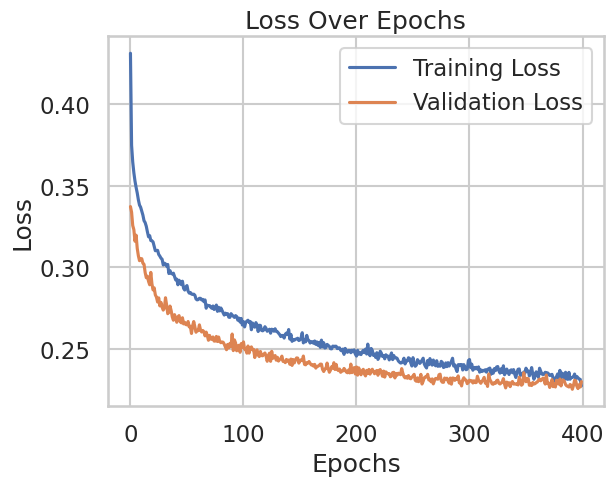

In [ ]:



X = model_data
y = y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features since they have different magnitudes
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Neural network model, activation used is relu (most common)
model = Sequential([
    Dense(256, activation='relu', input_shape=[X_train.shape[1]]),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model and save the training history
history = model.fit(X_train_scaled, y_train, epochs=400, batch_size=256, validation_split=0.2)

# Model evaluation
test_loss = model.evaluate(X_test_scaled, y_test)
print(f'MSE for the test: {test_loss}')
# Plotting the loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()


If we observe the plot for the loss over epochs, it is clear to see that, at first, the loss decreases drastically. Later, it will converge to the loss value and stay constant throughout all the other epochs left.
The result we get in this plot is the result we expected since the loss was expected to decrease at first and then converge.

In [ ]:
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)


train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = train_mse ** 0.5
train_r2 = r2_score(y_train, y_train_pred)

# Calculating  Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R2
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = test_mse ** 0.5
test_r2 = r2_score(y_test, y_test_pred)

#Printing out the results

print(f'MSE for train: {train_mse}')
print(f'RMSE for train: {train_rmse}')
print(f'R2 for train: {train_r2}')

print(f'MSE for test: {test_mse}')
print(f'RMSE for test: {test_rmse}')
print(f'R2 for test: {test_r2}')

722/722 [==============================] - 2s 2ms/step
MSE for train: 0.20037733570331592
RMSE for train: 0.44763527084370364
R2 for train: 0.7992521122431385
MSE for test: 0.2327073383934005
RMSE for test: 0.4823974900363812
R2 for test: 0.7689981368056281


We can see that Neural Network has a pretty good $R^2$ and low MSE and RMSE but Random Forset gave us best results.

# **Interpretation**

**<h3>Statistical Conclusions</h3>**

When testing against test data, we found that our models had the following MSE, RMSE and R2 scores:

<table ><tr><th>Model<th><th>MSE<th><th>RMSE<th><th>R2<th><tr>
  <tr>
    <td>Linear Regression<td><td>0.414<td><td>0.634<td><td>0.599<td>
  <tr>
  <tr>
    <td>Lasso Regression<td><td>0.417<td><td>0.646<td><td>0.596<td>
  <tr>
  <tr>
    <td>KNN<td><td>0.248<td><td>0.498<td><td>0.760<td>
  <tr>
  <tr>
    <td>Random Forest Tree<td><td>0.208<td><td>0.456<td><td>0.839<td>
  <tr>
  <tr>
    <td>Neural Network<td><td>0.232<td><td>0.482<td><td>0.769<td>
  <tr>
<table>

Based on these statistics, the **Random Forest model** emerged as the best model for predicting a used vehicle's price, with a Mean Squared Error of 0.208, a Root Mean Squared Error of 0.456, and an R² Score of 0.839. This model not only provided the lowest error metrics but also the highest explanatory power regarding the variance in vehicle prices.

**<h3>Importance</h3>**

In summary, the significant and growing reliance on used vehicles in American daily life, coupled with rising vehicle prices, underscores the importance of effectively navigating the automotive market. Our project aimed to meet this need by developing a reliable price predictor for used cars, ensuring that individuals receive a fair price on their used vehicles. Ultimately, this project seeks to empower individuals with the knowledge needed to make informed decisions when purchasing or selling a car.

As we conclude our exploration of various predictive models for used car prices, we have traversed a comprehensive journey from data preparation to advanced modeling techniques. Our project has demonstrated the effectiveness of multiple algorithms, each with its strengths and nuances, in the context of a real-world application that impacts everyday financial decisions.

**Closing Thoughts**


This project underscores the power of data science and machine learning in transforming raw data into actionable insights. By carefully tuning our models and selecting the right tool for the job, we have developed a system that not only predicts with accuracy but also enhances our understanding of the used car market.


We hope this project serves as a valuable resource for those looking to navigate the complexities of used vehicle pricing and as a stepping stone for further research and development in predictive modeling.


Thank you for joining us on this analytical journey. We look forward to future opportunities to explore and innovate together in the realm of data science.


![Thank You](https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExaTNlYTFrZWxqNWc1M3FzZzNrcjNxN3B2Mm52a2tkMmY3N3F2bmRkcSZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/3oz8xIsloV7zOmt81G/giphy.gif)